In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e12/sample_submission.csv
/kaggle/input/playground-series-s4e12/train.csv
/kaggle/input/playground-series-s4e12/test.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pylab
import re

from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import OneHotEncoder, StandardScaler 

from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, roc_curve, auc, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

import optuna
import warnings
warnings.filterwarnings('ignore')

In [4]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv',index_col='id' )
df_test = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv',index_col='id' )
df_sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e12/sample_submission.csv')

In [5]:
y = df_train['Premium Amount']
X = df_train.drop(columns=['Premium Amount']) 

In [6]:
df_train.isna().sum()

Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1181295 non-null  float64
 1   Gender                1200000 non-null  object 
 2   Annual Income         1155051 non-null  float64
 3   Marital Status        1181471 non-null  object 
 4   Number of Dependents  1090328 non-null  float64
 5   Education Level       1200000 non-null  object 
 6   Occupation            841925 non-null   object 
 7   Health Score          1125924 non-null  float64
 8   Location              1200000 non-null  object 
 9   Policy Type           1200000 non-null  object 
 10  Previous Claims       835971 non-null   float64
 11  Vehicle Age           1199994 non-null  float64
 12  Credit Score          1062118 non-null  float64
 13  Insurance Duration    1199999 non-null  float64
 14  Policy Start Date     1200000 non-null 

In [8]:
numerical_columns = X.select_dtypes(include=['number']).columns
categorical_columns = X.select_dtypes(include=['object']).columns

In [9]:
numerical_columns

Index(['Age', 'Annual Income', 'Number of Dependents', 'Health Score',
       'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration'],
      dtype='object')

In [10]:
categorical_columns

Index(['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
       'Policy Type', 'Policy Start Date', 'Customer Feedback',
       'Smoking Status', 'Exercise Frequency', 'Property Type'],
      dtype='object')

In [11]:

categorical_columns = categorical_columns.drop('Policy Start Date')

In [12]:
df_train['Annual Income'].quantile(0.025)

735.0

### Exploratory Data Analysis

In [13]:
# Calculate missing percentages
categorical_missing_percentages = df_train[categorical_columns].isnull().sum() / len(df_train) * 100
categorical_missing_percentages = categorical_missing_percentages[categorical_missing_percentages > 0]

categorical_missing_percentages

Marital Status        1.544083
Occupation           29.839583
Customer Feedback     6.485333
dtype: float64

In [ ]:
# Create the barplot
sns.barplot(x=categorical_missing_percentages.index, y=categorical_missing_percentages.values)

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Label the axes
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')

# Display the plot
plt.show()

In [ ]:
# Calculate missing percentages for numerical columns
numerical_missing_percentages = df_train[numerical_columns].isnull().sum() / len(df_train) * 100
numerical_missing_percentages = numerical_missing_percentages[numerical_missing_percentages > 0]

numerical_missing_percentages

In [ ]:
# Create the barplot
sns.barplot(x=numerical_missing_percentages.index, y=numerical_missing_percentages.values)

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Label the axes
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')

# Display the plot
plt.show()

### Exploratory Data Analytics

#### Target Variable Analysis

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 2]})

# Box plot on the left
sns.boxplot(y=df_train['Premium Amount'], ax=axes[0], color='skyblue')
axes[0].set(title='Box Plot of Premium Amount', xlabel='', ylabel='Premium Amount')

# Histogram with KDE on the right
sns.histplot(df_train['Premium Amount'], kde=True, bins=50, ax=axes[1], color='green')
axes[1].set(title='Histogram and KDE of Premium Amount', xlabel='Premium Amount', ylabel='Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

### Categorical Variables Distribution with Premium Amount

In [ ]:

for column in categorical_columns:
    print(f'Column: {column}')
    print(df_train[column].value_counts())

In [ ]:
df_train[categorical_columns].isna().sum()

In [ ]:
# Using sns.displot for faceted histogram
sns.displot(
    data=df_train,
    x='Premium Amount',
    col='Marital Status',
    kde=True,  # Add KDE curve for smoothness
    col_wrap=3,  # Number of facets per row (adjust as needed)
    bins=10,  # Number of bins
    height=4,  # Height of each facet
    aspect=1.2,  # Aspect ratio of each facet
    palette = 'Set2'# Optional color
)

# Adding a title to the entire plot
plt.subplots_adjust(top=0.9)
plt.suptitle('Distribution of Premium Amount Faceted by Marital Status', fontsize=16)

# Show the plot
plt.show()

In [ ]:
# Using sns.displot for faceted histogram
sns.displot(
    data=df_train,
    x='Premium Amount',
    col='Occupation',
    kde=True,  # Add KDE curve for smoothness
    col_wrap=3,  # Number of facets per row (adjust as needed)
    bins=10,  # Number of bins
    height=4,  # Height of each facet
    aspect=1.2,  # Aspect ratio of each facet
    palette = 'Set2'# Optional color
)

# Adding a title to the entire plot
plt.subplots_adjust(top=0.9)
plt.suptitle('Distribution of Premium Amount Faceted by Occupation', fontsize=16)

# Show the plot
plt.show()

In [ ]:
# Using sns.displot for faceted histogram
sns.displot(
    data=df_train,
    x='Premium Amount',
    col='Education Level',
    kde=True,  # Add KDE curve for smoothness
    col_wrap=3,  # Number of facets per row (adjust as needed)
    bins=10,  # Number of bins
    height=4,  # Height of each facet
    aspect=1.2,  # Aspect ratio of each facet
    palette = 'Set2'# Optional color
)

# Adding a title to the entire plot
plt.subplots_adjust(top=0.9)
plt.suptitle('Distribution of Premium Amount Faceted by Education Level', fontsize=16)

# Show the plot
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 2]})

# Box plot on the left
sns.boxplot(y=df_train['Annual Income'], ax=axes[0], color='skyblue')
axes[0].set(title='Box Plot of Annual Income', xlabel='', ylabel='Annual Income')

# Histogram with KDE on the right
sns.histplot(df_train['Annual Income'], kde=True, bins=15, ax=axes[1], color='green')
axes[1].set(title='Histogram and KDE of Annual Income', xlabel='Annual Income', ylabel='Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Line plot with seaborn
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_train,
    x='Number of Dependents', 
    palette='viridis',         # Optional color palette
    linewidth=2                # Line thickness
)

# Adding labels and title
plt.title(' Number of Dependents Distribution', fontsize=16)  
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Line plot with seaborn
plt.figure(figsize=(12, 6))
sns.histplot(
    x=df_train['Credit Score'], 
    palette='viridis',         # Optional color palette
    kde=True,
    bins=10
)

# Adding labels and title
plt.title(' Credit Score Distribution', fontsize=16)  
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_train,
    x='Policy Type',
    y='Premium Amount',
    ci=None,  # Remove confidence intervals for cleaner visualization
    palette='Set2'
)

# Adding labels and title
plt.title('Average Premium Amount by Policy Type', fontsize=16)
plt.xlabel('Policy Type', fontsize=14)
plt.ylabel('Average Premium Amount', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

### Feature Engineering

#### Categorical Column Missing Value Impute

In [14]:

class NumericalImputer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to impute numerical columns with specified strategies.
    """
    def __init__(self, impute_dict=None):
        """
        Initialize the transformer with a dictionary of imputation strategies.

        Args:
        - impute_dict (dict): Dictionary mapping column names to imputation strategies.
          e.g., {'Age': 'median', 'Number of Dependents': 0}
        """
        self.impute_dict = impute_dict

    def fit(self, X, y=None):
        """
        Fit the transformer by calculating the required statistics for each column.

        Args:
        - X (pd.DataFrame): Input data.
        - y: Ignored.
        
        Returns:
        - self: Fitted transformer.
        """
        self.statistics_ = {}
        for col, strategy in self.impute_dict.items():
            if strategy == "median":
                self.statistics_[col] = X[col].median()
            elif strategy == "mean":
                self.statistics_[col] = X[col].mean()
            elif strategy == 0:  # Use 0 for imputation
                self.statistics_[col] = 0
            else:
                raise ValueError(f"Unsupported strategy: {strategy}")
        return self

    def transform(self, X):
        """
        Transform the data by imputing the specified columns.

        Args:
        - X (pd.DataFrame): Input data.

        Returns:
        - pd.DataFrame: Transformed data with imputed values.
        """
        X = X.copy()
        for col, value in self.statistics_.items():
            X[col] = X[col].fillna(value)
        return X

    def get_feature_names_out(self, input_features=None):
        """
        Get output feature names for compatibility with ColumnTransformer.

        Args:
        - input_features (array-like or None): Input feature names. Ignored.

        Returns:
        - list: Feature names (column names) after transformation.
        """
        return list(self.impute_dict.keys())

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from datetime import datetime

class DateTimeConverter(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names_ = None  # Initialize a variable to store feature names

    def fit(self, X, y=None):
        # Save feature names during the fit step (this is the DataFrame's column names)
        self.feature_names_ = X.columns
        return self

    def transform(self, X):
        # Ensure input is a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")

        # Convert the date columns to datetime format
        X_transformed = X.apply(pd.to_datetime, errors='coerce')  # Invalid dates will become NaT
        
        # Calculate the number of days from today
        today = datetime.today()
        days_from_today = X_transformed.apply(lambda col: (today - col).dt.days)
        
        return days_from_today

    def get_feature_names_out(self, input_features=None):
        if self.feature_names_ is None:
            raise RuntimeError("The transformer has not been fit yet.")
        return self.feature_names_

In [16]:
# Custom Categorical Imputer Class
class CategoricalImputer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to impute categorical columns with a specified fill value.
    """
    def __init__(self, columns=None, fill_value="Not Available"):
        """
        Initialize the transformer.

        Args:
        - columns (list): List of column names to impute.
        - fill_value (str): The value to impute missing entries with. Defaults to 'Not Available'.
        """
        self.columns = columns
        self.fill_value = fill_value

    def fit(self, X, y=None):
        """
        Fit the transformer. This is a no-op as no fitting is required for simple imputation.

        Args:
        - X (pd.DataFrame): Input data.
        - y: Ignored.
        
        Returns:
        - self: Fitted transformer.
        """
        if self.columns is None:
            self.columns = X.columns.tolist()  # If no specific columns, impute all.
        return self

    def transform(self, X):
        """
        Transform the data by imputing the specified columns.

        Args:
        - X (pd.DataFrame): Input data.

        Returns:
        - pd.DataFrame: Transformed data with imputed values.
        """
        X = X.copy()
        for col in self.columns:
            X[col] = X[col].fillna(self.fill_value)
        return X

    def get_feature_names_out(self, input_features=None):
        """
        Get output feature names for compatibility with ColumnTransformer.

        Args:
        - input_features (array-like or None): Input feature names. Ignored in this implementation.

        Returns:
        - list: Feature names (column names) after transformation.
        """
        return self.columns

In [17]:

# Create the CategoricalImputer instance 
categorical_imputer =  CategoricalImputer()

categorical_imputer_pipeline = Pipeline(steps=[
     ('impute_value', categorical_imputer),
     ('ohe_impute_col',OneHotEncoder(handle_unknown='ignore', drop='first') )
 ])

In [18]:
 df_train['Policy Start Date'].isna().sum()

0

In [19]:

# Define the imputation strategies
impute_strategies = {
    'Age': 'median',
    'Annual Income': 'median',
    'Number of Dependents': 0,
    'Health Score': 'mean',
    'Previous Claims': 0,
    'Vehicle Age': 'median',
    'Credit Score': 'median',
    'Insurance Duration': 'median'
}

# Create the custom transformer for numerical imputation
numerical_imputer = NumericalImputer(impute_dict=impute_strategies)

# Define the numerical pipeline
numerical_pipeline = Pipeline(steps=[
    ('num_processing', numerical_imputer),  # Apply numerical imputation and outlier handling
    ('scaling', StandardScaler())  # Apply standard scaling
])


In [20]:

# Example columns
date_columns = ['Policy Start Date']

date_pipeline = Pipeline(steps = [
    ("date_transformation",DateTimeConverter()),
])

In [22]:

# Define the categorical columns to be imputed
categorical_impute_columns = ['Marital Status', 'Occupation', 'Customer Feedback']
remaining_cat_columns = [col for col in categorical_columns if col not in categorical_impute_columns]

# ColumnTransformer with preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('date_transform',date_pipeline, date_columns ),
        ("cat_transformation", OneHotEncoder(handle_unknown='ignore', drop='first'), remaining_cat_columns),  # OneHotEncode other categorical columns
        ("cat_impute_transformation", categorical_imputer_pipeline, categorical_impute_columns),  # Impute categorical columns 
        ("num_transformation", numerical_pipeline, numerical_columns),  # Apply numerical transformations
    ],
    remainder='passthrough'  # Pass through any columns not explicitly transformed
)
 
# Create a pipeline with PCA or any other estimator after preprocessing
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)  # Apply preprocessing for both categorical and numerical columns
])


In [23]:
pipeline.fit(X)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date_transform',
                                                  Pipeline(steps=[('date_transformation',
                                                                   DateTimeConverter())]),
                                                  ['Policy Start Date']),
                                                 ('cat_transformation',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Gender', 'Education Level',
                                                   'Location', 'Policy Type',
                                                   'Smoking Status',
                                                   'Exercise Frequency',...
                                                                   NumericalImputer(impute_dict={'Age': 'median',
                                                                                                 'Annual Income': 'median',
                                                                                                 'Credit Score': 'median',
                                                                                                 'Health Score': 'mean',
                                                                                                 'Insurance Duration': 'median',
                                                                                                 'Number of Dependents': 0,
                                                                                                 'Previous Claims': 0,
                                                                                                 'Vehicle Age': 'median'})),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Annual Income', 'Number of Dependents', 'Health Score',
       'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration'],
      dtype='object'))]))])

In [24]:
transformed_X = pipeline.transform(X)


In [25]:
 # Get the feature names after transformation
transformed_feature_names = preprocessor.get_feature_names_out()
transformed_feature_names


array(['date_transform__Policy Start Date',
       'cat_transformation__Gender_Male',
       'cat_transformation__Education Level_High School',
       "cat_transformation__Education Level_Master's",
       'cat_transformation__Education Level_PhD',
       'cat_transformation__Location_Suburban',
       'cat_transformation__Location_Urban',
       'cat_transformation__Policy Type_Comprehensive',
       'cat_transformation__Policy Type_Premium',
       'cat_transformation__Smoking Status_Yes',
       'cat_transformation__Exercise Frequency_Monthly',
       'cat_transformation__Exercise Frequency_Rarely',
       'cat_transformation__Exercise Frequency_Weekly',
       'cat_transformation__Property Type_Condo',
       'cat_transformation__Property Type_House',
       'cat_impute_transformation__Marital Status_Married',
       'cat_impute_transformation__Marital Status_Not Available',
       'cat_impute_transformation__Marital Status_Single',
       'cat_impute_transformation__Occupation_Not

In [26]:
df_transformed_X =  pd.DataFrame(transformed_X, columns=transformed_feature_names)


In [27]:
df_transformed_X.head()

,date_transform__Policy Start Date,cat_transformation__Gender_Male,cat_transformation__Education Level_High School,cat_transformation__Education Level_Master's,cat_transformation__Education Level_PhD,cat_transformation__Location_Suburban,cat_transformation__Location_Urban,cat_transformation__Policy Type_Comprehensive,cat_transformation__Policy Type_Premium,cat_transformation__Smoking Status_Yes,...,cat_impute_transformation__Customer Feedback_Not Available,cat_impute_transformation__Customer Feedback_Poor,num_transformation__Age,num_transformation__Annual Income,num_transformation__Number of Dependents,num_transformation__Health Score,num_transformation__Previous Claims,num_transformation__Vehicle Age,num_transformation__Credit Score,num_transformation__Insurance Duration
0,354.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,-1.648301,-0.707414,-0.562091,-0.255071,1.383143,1.286338,-1.567375,-0.007023
1,548.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,-0.159542,-0.023289,0.798510,-0.849704,0.320400,0.420713,0.714630,-1.163391
2,438.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,-1.350549,-0.215473,0.798510,1.824212,0.320400,0.766963,0.013020,-0.777935
3,182.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,-1.499425,3.461605,0.118210,-1.241521,0.320400,-1.656788,-1.602810,-1.548847
4,1106.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,-1.499425,0.228896,-0.562091,-0.443102,-0.742343,-0.271787,0.034281,-0.392479


### Transform Test Data

In [28]:
test_transformed = pipeline.transform(df_test)

In [29]:
df_test_transformed=  pd.DataFrame(test_transformed, columns=transformed_feature_names)


In [30]:
df_test_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 32 columns):
 #   Column                                                      Non-Null Count   Dtype  
---  ------                                                      --------------   -----  
 0   date_transform__Policy Start Date                           800000 non-null  float64
 1   cat_transformation__Gender_Male                             800000 non-null  float64
 2   cat_transformation__Education Level_High School             800000 non-null  float64
 3   cat_transformation__Education Level_Master's                800000 non-null  float64
 4   cat_transformation__Education Level_PhD                     800000 non-null  float64
 5   cat_transformation__Location_Suburban                       800000 non-null  float64
 6   cat_transformation__Location_Urban                          800000 non-null  float64
 7   cat_transformation__Policy Type_Comprehensive               800000 non-nul

In [31]:
df_test_transformed

,date_transform__Policy Start Date,cat_transformation__Gender_Male,cat_transformation__Education Level_High School,cat_transformation__Education Level_Master's,cat_transformation__Education Level_PhD,cat_transformation__Location_Suburban,cat_transformation__Location_Urban,cat_transformation__Policy Type_Comprehensive,cat_transformation__Policy Type_Premium,cat_transformation__Smoking Status_Yes,...,cat_impute_transformation__Customer Feedback_Not Available,cat_impute_transformation__Customer Feedback_Poor,num_transformation__Age,num_transformation__Annual Income,num_transformation__Number of Dependents,num_transformation__Health Score,num_transformation__Previous Claims,num_transformation__Vehicle Age,num_transformation__Credit Score,num_transformation__Insurance Duration
0,556.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,-0.978359,-0.952198,1.478811,-1.519011,-0.742343,1.632588,0.013020,-1.548847
1,233.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,-0.755046,2.961093,0.118210,-1.034831,-0.742343,0.766963,-1.567375,1.149346
2,616.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.435961,-0.484644,-1.242391,-0.106539,-0.742343,1.113213,1.600501,1.534802
3,413.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,-0.978359,-0.062953,0.798510,-1.732344,0.320400,-1.137413,1.253240,-0.007023
4,1111.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,-1.276111,-0.681667,0.118210,-1.164875,-0.742343,0.766963,1.146935,0.763890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,1251.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.659275,0.201410,-0.562091,-0.940315,-0.742343,-0.271787,-2.013854,-1.163391
799996,624.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.010667,1.298337,-1.242391,-1.477748,1.383143,-1.656788,0.013020,-1.163391
799997,1899.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,-1.127235,0.087415,-1.242391,-1.605418,-0.742343,0.074463,0.013020,0.378433
799998,947.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,-0.531732,0.418992,0.798510,-0.818613,1.383143,1.286338,-0.894112,0.763890


### Apply Machine Learning Alogrithms

In [32]:
X_train,X_test,y_train,y_test = train_test_split(df_transformed_X,y)

#### XGBoost Regression

In [35]:
# Define an objective function for Optuna
def objective(trial):
    # Define hyperparameter search space
    param = {
        'n_estimators': 1000,  # Fixed value based on your grid
        'learning_rate': trial.suggest_categorical('learning_rate', [0.05, 0.1]),
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'subsample': trial.suggest_categorical('subsample', [0.8, 1.0]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.8, 1.0]),
    }

    # Create the model with the trial's parameters
    model = XGBRegressor(**param)

    # Perform cross-validation
    scores = cross_val_score(
        model, X_train, y_train, 
        scoring='neg_mean_squared_error', 
        cv=5
    )
    
    # Return the mean of negative MSE as the objective to minimize
    return -np.mean(scores)

# Create a study for optimization
study = optuna.create_study(direction='minimize')

# Optimize the study
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Print the best parameters and the best score
print("Best Parameters:", study.best_params)
print("Best CV Score (Negative MSE):", study.best_value)

# Train the final model with the best parameters
best_xg_model = XGBRegressor(**study.best_params)
best_xg_model.fit(X_train, y_train)

[I 2024-12-11 22:43:25,311] A new study created in memory with name: no-name-4a27dfe4-c2ca-42c8-a19d-dd7afb3b7506


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-12-11 22:45:08,647] Trial 0 finished with value: 729648.7110646839 and parameters: {'learning_rate': 0.05, 'max_depth': 2, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 0 with value: 729648.7110646839.
[I 2024-12-11 22:47:47,104] Trial 1 finished with value: 709354.656032537 and parameters: {'learning_rate': 0.1, 'max_depth': 4, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 1 with value: 709354.656032537.
[I 2024-12-11 22:50:20,159] Trial 2 finished with value: 710518.1664785112 and parameters: {'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is trial 1 with value: 709354.656032537.
[I 2024-12-11 22:52:28,514] Trial 3 finished with value: 715995.6562386288 and parameters: {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is trial 1 with value: 709354.656032537.
[I 2024-12-11 22:54:59,379] Trial 4 finished with value: 710518.1664785112 and parameters: {'learning_rate': 0.05, 'ma

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

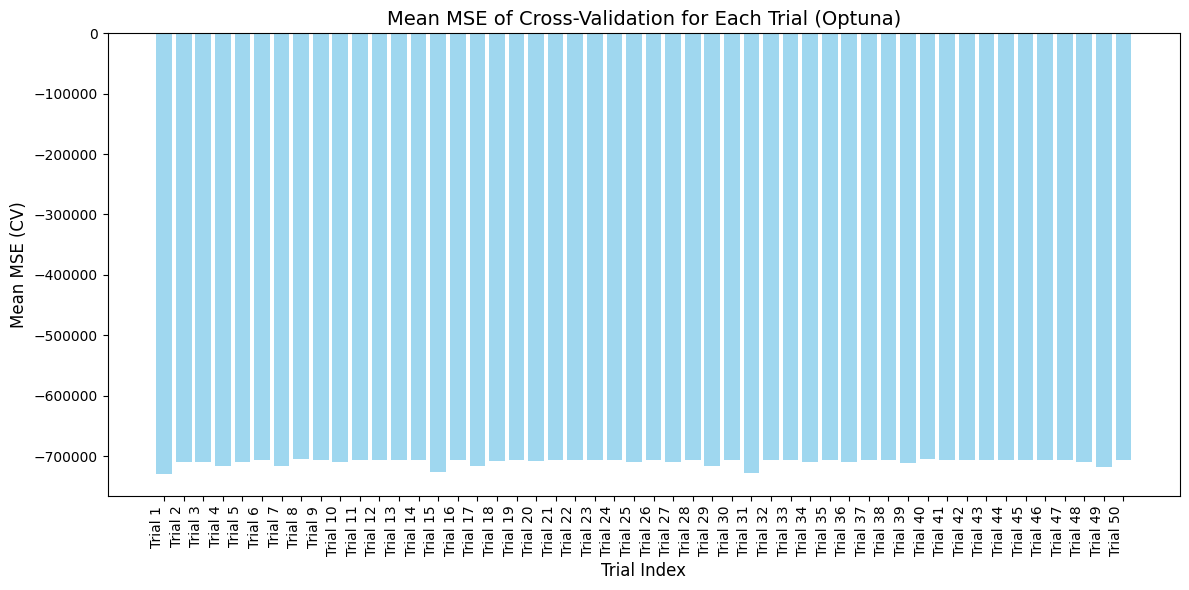

In [36]:
# Extract parameter combinations and corresponding MSEs from Optuna trials
trial_params = [trial.params for trial in study.trials]
trial_mse = [-trial.value for trial in study.trials]  # Convert Optuna's minimization objective

# Create x_labels for each parameter set
x_labels = [f"Trial {i+1}" for i in range(len(trial_mse))]
x_pos = np.arange(len(trial_mse))

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(x_pos, trial_mse, color='skyblue', alpha=0.8)

# Add labels and title
plt.xlabel("Trial Index", fontsize=12)
plt.ylabel("Mean MSE (CV)", fontsize=12)
plt.title("Mean MSE of Cross-Validation for Each Trial (Optuna)", fontsize=14)
plt.xticks(x_pos, x_labels, rotation=90, ha='right', fontsize=10)
plt.tight_layout()

plt.show()

In [37]:
# Predict on test data
y_pred = best_xg_model.predict(X_test)

# Calculate MSE and R-squared
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Test Mean Squared Error (MSE): {test_mse:.4f}")
print(f"Test R-squared (R2): {test_r2:.4f}")

Test Mean Squared Error (MSE): 709955.7990
Test R-squared (R2): 0.0508


In [43]:

# Print the best parameters and the best score
print("Best Parameters:", study.best_params)
print("Best CV Score (Negative MSE):", study.best_value) 


Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'subsample': 1.0, 'colsample_bytree': 1.0}
Best CV Score (Negative MSE): 705512.3020998879


In [46]:

# Make predictions on the test set
y_pred_xgb = best_xg_model.predict(df_test_transformed)


In [48]:
output_xgb = pd.DataFrame(y_pred_xgb, index=df_test.index, columns=['Premium Amount']).reset_index()

In [49]:
output_xgb.head(20)

,id,Premium Amount
0,1200000,1314.271973
1,1200001,1115.126709
2,1200002,1078.612793
3,1200003,1061.825928
4,1200004,1019.373352
5,1200005,1145.861694
6,1200006,1217.985474
7,1200007,1023.520447
8,1200008,536.737671
9,1200009,1072.506836


In [50]:
submission = output_xgb.to_csv('/kaggle/working/submission.csv', index=False)

In [51]:

# Create a DataFrame to show the importance of each original feature
importance_df = pd.DataFrame({
    'Original Feature': transformed_feature_names,  # Replace with actual feature names
    'Importance': best_xg_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                                     Original Feature  Importance
22  cat_impute_transformation__Customer Feedback_N...    0.278135
28                num_transformation__Previous Claims    0.153643
25                  num_transformation__Annual Income    0.111492
30                   num_transformation__Credit Score    0.093857
0                   date_transform__Policy Start Date    0.079603
27                   num_transformation__Health Score    0.046734
16  cat_impute_transformation__Marital Status_Not ...    0.042482
18  cat_impute_transformation__Occupation_Not Avai...    0.013028
15  cat_impute_transformation__Marital Status_Married    0.008675
8             cat_transformation__Policy Type_Premium    0.008641
19  cat_impute_transformation__Occupation_Self-Emp...    0.008319
3        cat_transformation__Education Level_Master's    0.008233
12      cat_transformation__Exercise Frequency_Weekly    0.008213
5               cat_transformation__Location_Suburban    0.008208
11      ca

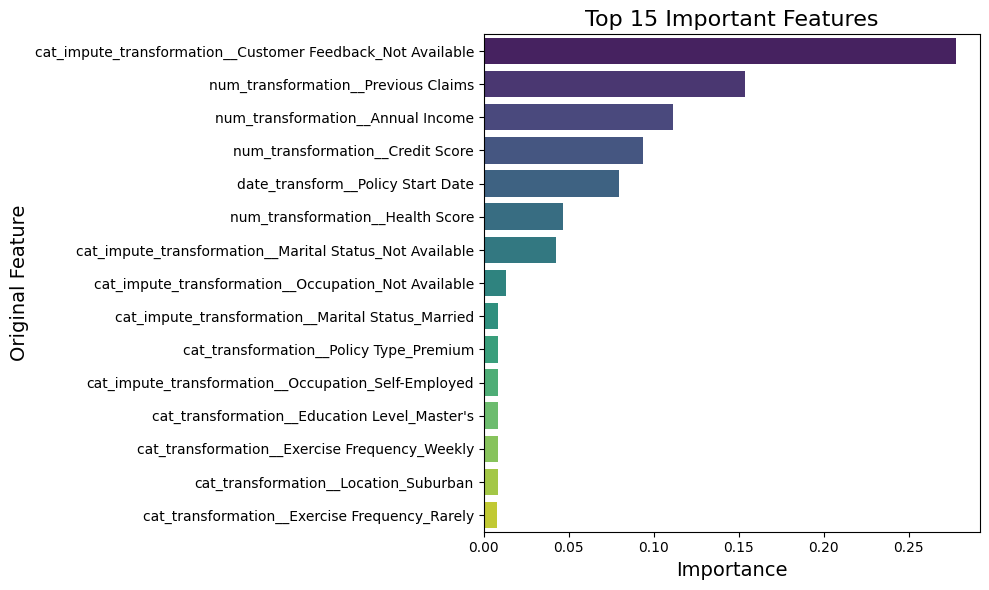

In [52]:
# Assuming the importance_df is already computed as described earlier:
# Sort the DataFrame by importance in descending order and select top 15 features
top_features = importance_df.sort_values(by='Importance', ascending=False).head(15)

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Original Feature', data=top_features, palette='viridis')

# Add labels and title
plt.title('Top 15 Important Features', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Original Feature', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()